
# CXC Datathon - Intact Data Science Challenge
#### Predict Medical Specialty from Medical Notes

## Description:

*   Intact's claims department receives thousands of documents every day. Among these are medical documents, as Intact provides compensation to those who have sustained injuries in automobile accidents. Due to the volume of data received on a daily basis, it is difficult to keep every document neatly organized for easy retrieval. Thus, it would be helpful to have a system that automatically makes sense of the content of the document and can classify it into one of a set number of categories.

*   Our group classifies each medical transcription to a medical specialty
*   The evaluation is based on F1-score with macro averaging on the test set

## Methods:

*   Data Exploration 
 * Plots for showing basic information in text words
*   Data Preprocessing
  * Preprocess the text words for better analysis
*   Data Modeling
  *   Split train/test sets for model comparison
  *   Normal Classification Models (Xgboost, SVM, Rigid Classifier)
  *   Pre-trained Model - BERT

### Hyperlinks:
*   [Data Exploration](#3)
*   [Data Preprocessing](#4)
*   [Data Modeling - Normal Classification Models](#5)
*   [Data Modeling - BERT](#6)
*   [Submission](#7)







# Import packages

In [1]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [2]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 50.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 53.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 9.1 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import torch

import string
import re
import spacy

from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
#from pywsd.utils import lemmatize_sentence

import itertools
from tqdm.auto import tqdm
tqdm.pandas()
from multiprocessing import Pool

from sklearn.model_selection import train_test_split, KFold

from keras.preprocessing.text import Tokenizer
import os
import sys

from wordcloud import WordCloud
from wordcloud import STOPWORDS

from sklearn.feature_extraction.text import TfidfVectorizer
from xgboost import XGBClassifier
from sklearn.model_selection import cross_validate, cross_val_predict
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score, recall_score, precision_score, accuracy_score, f1_score
from sklearn.metrics import classification_report, accuracy_score, balanced_accuracy_score
from sklearn.linear_model import RidgeClassifier
from sklearn.svm import SVC

In [4]:
from transformers import BertTokenizer
from torch.utils.data import TensorDataset
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
import random

# Read data

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
path = "/content/drive/MyDrive/CXC DS Competition/1. Intact (main)"# where the data located
train_df = pd.read_csv(os.path.join(path, f"new_train.csv"), index_col=0)
test_df = pd.read_csv(os.path.join(path, f"new_test.csv"), index_col=0)

print("Train size", len(train_df))
print("Test size", len(test_df))
train_df.head(n=3)

Train size 3969
Test size 997


,medical_specialty,transcription,labels
0,Emergency Room Reports,"REASON FOR THE VISIT:, Very high PT/INR.,HIST...",0
1,Surgery,"PREOPERATIVE DIAGNOSIS:, Acetabular fracture ...",1
2,Surgery,"NAME OF PROCEDURE,1. Selective coronary angio...",1


In [7]:
test_df.head(n=3)

,transcription
0,"PAST MEDICAL CONDITION:, None.,ALLERGIES:, N..."
1,"CURRENT HISTORY:, A 94-year-old female from t..."
2,"TITLE OF PROCEDURE: ,Coronary artery bypass g..."


<a name="3"></a>
# Data Exploration

## Description


*   Distribution of number of words plot - overview for how many words in each document
*   Distribution of words length plot - overview for each word's length in all document
*   Distribution of top stop words plot - find the number of stopwords
*   Label Distribution Plot - shows the distribution of number of each label



In [8]:
def plot_top_stopwords_barchart(text):
    stop=set(stopwords.words('english'))
    
    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]
    from collections import defaultdict
    dic=defaultdict(int)
    for word in corpus:
        if word in stop:
            dic[word]+=1
            
    top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
    x,y=zip(*top)
    plt.bar(x,y)
    plt.title('Distribution of top stopwords')
    plt.xlabel('Stopwords')
    plt.ylabel('Counts')
    plt.savefig('histogram_top_stopword.png')

def plot_word_number_histogram(text):
    text.str.split().\
        map(lambda x: len(x)).\
        hist()
    plt.title('Distribution of number of words')
    plt.xlabel('Number of words')
    plt.ylabel('Counts')

def plot_word_length_histogram(text):
    x = text.str.split().\
        apply(lambda x : [len(i) for i in x]). \
        map(lambda x: np.mean(x))
    plt.hist(x, bins = 15, range=(0, 15))
    plt.title('Distribution of words length')
    plt.xlabel('Words Length')
    plt.ylabel('Counts')
    plt.savefig('histogram_word_length.png')

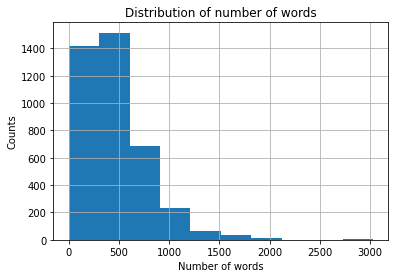

In [9]:
plot_word_number_histogram(train_df['transcription'])

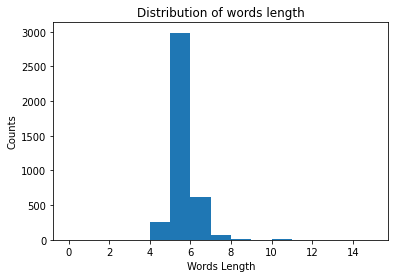

In [10]:
plot_word_length_histogram(train_df['transcription'])

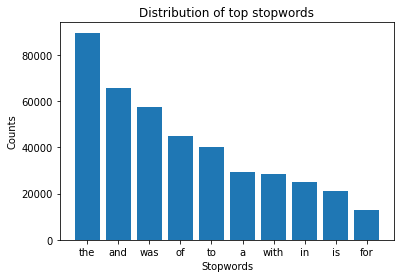

In [11]:
plot_top_stopwords_barchart(train_df['transcription'])

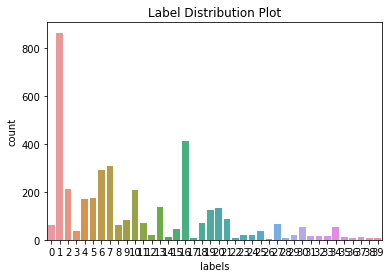

In [12]:
ax = sns.countplot(x=train_df['labels'])
ax.set_title('Label Distribution Plot')
plt.savefig('label.png')

<a name="4"></a>
# Data preprocessing

## Description

*   Lowercase
*   Remove Numbers
*   Convert short words such as I'm, He's
*   Remove punctuations
*   Remove stop words
*   Lemmization



In [13]:
# lowercase
def lower(df, cols):
    for col in tqdm(cols):
        df[col] = df[col].progress_apply(lambda x: x.lower())
    return df

# number removing
def num_remove(df, cols):
    for col in tqdm(cols):
        df[col] = df[col].progress_apply(lambda x: re.sub(r'\d+', '', x))
    return df

# white spaces removal
def space_remove(df,cols):
    for col in tqdm(cols):
        df[col] = df[col].progress_apply(lambda x: x.strip()) # remove front and end space
        df[col] = df[col].str.replace('\s+', ' ', regex=True) # remove double space
    return df

def to_sentence(df,cols):
    # join words to a sentence
    for col in tqdm(cols):
        df[col] = df[col].progress_apply(lambda x: ' '.join(x))
    return df

# punctuation removal
def punc_remove(df,cols):
    for col in tqdm(cols):
        df[col] = df[col].progress_apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
    return df

# stemming
def stemming(df,cols):
    porter_stemmer  = PorterStemmer()
    for col in tqdm(cols):
        df[col] = df[col].progress_apply(lambda x: [porter_stemmer.stem(w) for w in x.split()])
    df = to_sentence(df,cols)
    return df

# convert short words and urls
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    urlPattern = r"((http://)|(https://)|( www\.)|(com)|(net)|(org))"
    phrase = re.sub(urlPattern,'',phrase)
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

# convert cases such as he's, I'm, ...
def short_word_converter(df,cols):
    nlp = spacy.load("en_core_web_sm")
    for col in tqdm(cols):
        df[col] = df[col].progress_apply(lambda x: decontracted(x))
    return df

# stop word removal
def stop_remove(df,cols):
    stops = set(stopwords.words('english'))
    for col in tqdm(cols):
        df[col] = df[col].progress_apply(lambda x: ' '.join([word for word in x.split() if word not in stops]))
    #df = to_sentence(df,cols)
    return df

# run all preprocessing functions
def preprocess(df,cols):
    df[cols] = lower(df,cols)[cols]
    df[cols] = num_remove(df,cols)[cols]
    #df[cols] = space_remove(df,cols)[cols]
    df[cols] = short_word_converter(df,cols)[cols] 
    #df[cols] = stemming(df,cols)[cols] 
    df[cols] = punc_remove(df,cols)[cols]
    df[cols] = stop_remove(df,cols)[cols]
    return df

In [14]:
train_df['transcription'][0]

'REASON FOR THE VISIT:,  Very high PT/INR.,HISTORY: , The patient is an 81-year-old lady whom I met last month when she came in with pneumonia and CHF.  She was noticed to be in atrial fibrillation, which is a chronic problem for her.  She did not want to have Coumadin started because she said that she has had it before and the INR has had been very difficult to regulate to the point that it was dangerous, but I convinced her to restart the Coumadin again.  I gave her the Coumadin as an outpatient and then the INR was found to be 12.  So, I told her to come to the emergency room to get vitamin K to reverse the anticoagulation.,PAST MEDICAL HISTORY:,1.  Congestive heart failure.,2.  Renal insufficiency.,3.  Coronary artery disease.,4.  Atrial fibrillation.,5.  COPD.,6.  Recent pneumonia.,7.  Bladder cancer.,8.  History of ruptured colon.,9.  Myocardial infarction.,10.  Hernia repair.,11.  Colon resection.,12.  Carpal tunnel repair.,13.  Knee surgery.,MEDICATIONS:,1.  Coumadin.,2.  Simva

In [15]:
train_df = preprocess(train_df,['transcription'])

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3969 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3969 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3969 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3969 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3969 [00:00<?, ?it/s]

In [16]:
test_df = preprocess(test_df,['transcription'])

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/997 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/997 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/997 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/997 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/997 [00:00<?, ?it/s]

In [17]:
train_df['transcription'][0]

'reason visit high ptinrhistory patient yearold lady met last month came pneumonia chf noticed atrial fibrillation chronic problem want coumadin started said inr difficult regulate point dangerous convinced restart coumadin gave coumadin outpatient inr found told e emergency room get vitamin k reverse anticoagulationpast medical history congestive heart failure renal insufficiency coronary artery disease atrial fibrillation copd recent pneumonia bladder cancer history ruptured colon myocardial infarction hernia repair colon resection carpal tunnel repair knee surgerymedications coumadin simvastatin nitrofurantoin celebrex digoxin levothyroxine vicodin triamterene hydrochlorothiazide carvedilolsocial history smoke drinkphysical examinationgeneral lady distressvital signs blood pressure pulse respirations temperature heent head normalneck supplelungs clear auscultation percussionheart murmursabdomen softextremities lower extremities edemaassessment atrial fibrillation coagulopathy induce

In [18]:
# Tokenizing and keep only nouns

train_df['tokenized_sents'] = train_df['transcription'].apply(nltk.word_tokenize) # create a column for tokens
train_df['POSTags'] = train_df['tokenized_sents'].apply(pos_tag) # to record parts of speech for each token
# keep only nouns
train_df['Nouns'] = train_df['POSTags'].apply(lambda x: [(t[0], t[1]) for t in x if t[1]=='NN' or t[1]=='NNP' or t[1]=='NNS' or t[1]=='NNPS'])

# further preprcessing
to_be_lemmatized = []

for nouns_per_medical_specialties in train_df['Nouns']:
  words2lemmatied = []

  for word in nouns_per_medical_specialties:
    words2lemmatied.append(word[0])
    
  to_be_lemmatized.append(words2lemmatied)

train_df['to_be_lemmatized'] = to_be_lemmatized

lmtzr = WordNetLemmatizer()

# lemmatize each token
train_df['lemmatize'] = train_df['to_be_lemmatized'].apply(lambda lst:[lmtzr.lemmatize(word) for word in lst])

train_df['tokenized_sents'] = train_df['tokenized_sents'].astype('str')
train_df['tokenized_sents']

# join tokens into sentences
train_df['lemmatize_to_string']= train_df['lemmatize'].str.join(" ")
print(train_df['lemmatize_to_string'][0])

reason visit ptinrhistory patient month chf fibrillation chronic problem coumadin regulate point coumadin outpatient inr emergency room k reverse history heart failure insufficiency artery disease fibrillation copd pneumonia bladder cancer history colon infarction hernia repair colon resection tunnel repair surgerymedications celebrex digoxin levothyroxine vicodin triamterene history lady sign blood pressure respiration head normalneck supplelungs auscultation percussionheart murmursabdomen softextremities extremity fibrillation coagulopathy office repeat vitamin k mg ml dw home repeat ptinr week time use coumadin case age medication level anticoagulation prone fall problem use aspirin day anticoagulation risk stroke anticoagulation coumadin use coumadin time see outpatient


In [19]:
# Tokenizing and keep only nouns

test_df['tokenized_sents'] = test_df['transcription'].apply(nltk.word_tokenize) # create a column for tokens
test_df['POSTags'] = test_df['tokenized_sents'].apply(pos_tag) # to record parts of speech for each token
# keep only nouns
test_df['Nouns'] = test_df['POSTags'].apply(lambda x: [(t[0], t[1]) for t in x if t[1]=='NN' or t[1]=='NNP' or t[1]=='NNS' or t[1]=='NNPS'])

# further preprcessing
to_be_lemmatized = []

for nouns_per_medical_specialties in test_df['Nouns']:
  words2lemmatied = []

  for word in nouns_per_medical_specialties:
    words2lemmatied.append(word[0])
    
  to_be_lemmatized.append(words2lemmatied)

test_df['to_be_lemmatized'] = to_be_lemmatized

lmtzr = WordNetLemmatizer()

# lemmatize each token
test_df['lemmatize'] = test_df['to_be_lemmatized'].apply(lambda lst:[lmtzr.lemmatize(word) for word in lst])

test_df['tokenized_sents'] = test_df['tokenized_sents'].astype('str')
test_df['tokenized_sents']

# join tokens into sentences
test_df['lemmatize_to_string']= test_df['lemmatize'].str.join(" ")
print(test_df['lemmatize_to_string'][0])

condition noneallergies medication zyrtec hydrocodone hour plaint injury rle symptomshistory patient evaluation patient state worker patient job furniture home patient week date injury patient history problem state day wheeler abc box load event patient pain afterwards symptom buttock way part leg knee leg increase buttock spasm buttock z muscle relaxer pain patch patch state treatment symptom point patient xyz workman evaluation patient mri pain medication opioids duty mri patient symptom extremity dr xyz june persistence pain radiating symptom dr xyz point patient medication management pain patient nerve block point patient injection dr abc relief patient nerve conduction study abcd mri nerve conduction study radiculopathy patient state symptom extremity side leg increase pain difficulty increase pain work june improvement patient degree pain activity radicular symptom side patient x specialist visit care relief examination patient lumbar flexion extension side side bending limit rot

In [20]:
train_df.head()

,medical_specialty,transcription,labels,tokenized_sents,POSTags,Nouns,to_be_lemmatized,lemmatize,lemmatize_to_string
0,Emergency Room Reports,reason visit high ptinrhistory patient yearold...,0,"['reason', 'visit', 'high', 'ptinrhistory', 'p...","[(reason, NN), (visit, NN), (high, JJ), (ptinr...","[(reason, NN), (visit, NN), (ptinrhistory, NN)...","[reason, visit, ptinrhistory, patient, month, ...","[reason, visit, ptinrhistory, patient, month, ...",reason visit ptinrhistory patient month chf fi...
1,Surgery,preoperative diagnosis acetabular fracture lef...,1,"['preoperative', 'diagnosis', 'acetabular', 'f...","[(preoperative, JJ), (diagnosis, NN), (acetabu...","[(diagnosis, NN), (fracture, NN), (columntrans...","[diagnosis, fracture, columntransverse, poster...","[diagnosis, fracture, columntransverse, poster...",diagnosis fracture columntransverse posterior ...
2,Surgery,name procedure selective coronary angiography ...,1,"['name', 'procedure', 'selective', 'coronary',...","[(name, NN), (procedure, NN), (selective, JJ),...","[(name, NN), (procedure, NN), (angiography, NN...","[name, procedure, angiography, placement, x, x...","[name, procedure, angiography, placement, x, x...",name procedure angiography placement x x stent...
3,Radiology,referring diagnosis motor neuron diseasepertin...,2,"['referring', 'diagnosis', 'motor', 'neuron', ...","[(referring, VBG), (diagnosis, NN), (motor, NN...","[(diagnosis, NN), (motor, NN), (diseasepertine...","[diagnosis, motor, diseasepertinent, history, ...","[diagnosis, motor, diseasepertinent, history, ...",diagnosis motor diseasepertinent history exami...
4,Emergency Room Reports,chief plaint dental painhistory present illnes...,0,"['chief', 'plaint', 'dental', 'painhistory', '...","[(chief, JJ), (plaint, NN), (dental, JJ), (pai...","[(plaint, NN), (painhistory, NN), (illness, NN...","[plaint, painhistory, illness, yearold, female...","[plaint, painhistory, illness, yearold, female...",plaint painhistory illness yearold female stat...


In training set, split train and validation sets

In [21]:
X = train_df['lemmatize_to_string']
y = train_df["labels"]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.30, random_state=100, stratify=y)

<a name="4"></a>
# Normal Classification Models

## Description

*   TFIDF vectorizer with unigrams and biagrams
*   Multinomial Naive Bayes classifier
*   XGBoost Classifier
*   Ridge Classifier
*   SVM

In [22]:
vectorizer_tfidf = TfidfVectorizer(min_df = 0.001, ngram_range = (1,2))
train_tfIdf = vectorizer_tfidf.fit_transform(X_train.values.astype('U'))
test_tfIdf = vectorizer_tfidf.transform(X_val.values.astype('U'))

In [23]:
# approach 1: Naive Bayes
# Multinomial Naive Bayes classifier
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

nb_classifier = MultinomialNB()

nb_classifier.fit(train_tfIdf, y_train)

# our model is trained and it is ready to generate predictions on the unseen data. 
y_pred = nb_classifier.predict(test_tfIdf) 

print('\nAccuracy: {:.2f}'.format(accuracy_score(y_val, y_pred)))
print('Balanced Accuracy: {:.2f}'.format(balanced_accuracy_score(y_val, y_pred)))
print('Macro F1-score: {:.2f}'.format(f1_score(y_val, y_pred, average='macro')))


Accuracy: 0.32
Balanced Accuracy: 0.05
Macro F1-score: 0.03


In [24]:
# approach 2: XGB classifier

#model = XGBClassifier(objective='multi:softmax', num_class=y_train.nunique(), eval_metric='mlogloss', random_state=1234) # if no GPU

# model
model = XGBClassifier(objective='multi:softmax', num_class=y.nunique(), eval_metric='mlogloss', tree_method= 'gpu_hist', random_state=1234)

# fit model
model.fit(train_tfIdf, y_train, verbose=0)

# get results
y_pred = model.predict(test_tfIdf)

print('\nAccuracy: {:.2f}'.format(accuracy_score(y_val, y_pred)))
print('Balanced Accuracy: {:.2f}'.format(balanced_accuracy_score(y_val, y_pred)))
print('Macro F1-score: {:.2f}'.format(f1_score(y_val, y_pred, average='macro')))


Accuracy: 0.08
Balanced Accuracy: 0.03
Macro F1-score: 0.02


In [25]:
# approach 3: Ridge Classifier

model2 = RidgeClassifier(alpha=26, solver="sparse_cg")
model2.fit(train_tfIdf, y_train)
y_pred = model2.predict(test_tfIdf)

print('\nAccuracy: {:.2f}'.format(accuracy_score(y_val, y_pred)))
print('Balanced Accuracy: {:.2f}'.format(balanced_accuracy_score(y_val, y_pred)))
print('Macro F1-score: {:.2f}'.format(f1_score(y_val, y_pred, average='macro')))


Accuracy: 0.32
Balanced Accuracy: 0.05
Macro F1-score: 0.04


In [26]:
# approsach 4: SVM
# Define the SVM classifier and fit the training data
svm = SVC(kernel='linear')
svm.fit(train_tfIdf, y_train)

# Evaluate the classifier on the testing data
y_pred = svm.predict(test_tfIdf)
print('\nAccuracy: {:.2f}'.format(accuracy_score(y_val, y_pred)))
print('Balanced Accuracy: {:.2f}'.format(balanced_accuracy_score(y_val, y_pred)))
print('Macro F1-score: {:.2f}'.format(f1_score(y_val, y_pred, average='macro')))


Accuracy: 0.24
Balanced Accuracy: 0.09
Macro F1-score: 0.09


<a name="6"></a>
# Bert Model

Description:

*   Accroding to the notebook Bert_2.ipynb, we decided the following model parameters:
*   Using bert-large-uncased pre-trained model
*   Number of Epoch = 4
*   Learning Rate = 1e-5
*   Batch size = 32
*   Eps = 1e-8



initial settings for BERT

In [27]:
n_epoch = 7
lr_rate = 1e-5
batch = 32
eps = 1e-8

In [28]:
# other tokenize methods: https://huggingface.co/docs/transformers/main_classes/tokenizer#:~:text=%E2%80%9CFast%E2%80%9D%20implementation
#tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased')

In [29]:
X_train = train_df['lemmatize_to_string']
y_train = train_df["labels"]
X_test = test_df['lemmatize_to_string']

In [30]:
X_train.shape

(3969,)

In [31]:
X_test.shape

(997,)

In [32]:
%%time
encoder_train = tokenizer.batch_encode_plus(X_train,
                                           add_special_tokens = True,
                                           pad_to_max_length = True,
                                           return_attention_mask=True,
                                           max_length = 256,
                                           return_tensors = 'pt')



encoder_test = tokenizer.batch_encode_plus(X_test,
                                           add_special_tokens = True,
                                           pad_to_max_length = True,
                                           return_attention_mask=True,
                                           max_length = 256,
                                           return_tensors = 'pt')

input_ids_train = encoder_train['input_ids']
#List of indices specifying which tokens should be attended to by the model 
attention_masks_train = encoder_train["attention_mask"]
labels_train = torch.tensor(pd.DataFrame(y_train).values)

input_ids_test = encoder_test['input_ids']
attention_masks_test = encoder_test["attention_mask"]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


CPU times: user 20 s, sys: 81.9 ms, total: 20.1 s
Wall time: 20 s


In [33]:
data_train = TensorDataset(input_ids_train,attention_masks_train,labels_train)
data_test = TensorDataset(input_ids_test,attention_masks_test)

## model performance functions

In [34]:
from sklearn.metrics import f1_score, accuracy_score
import random

def f1_score_func(preds,labels):
    preds_flat = np.argmax(preds,axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat,preds_flat,average = 'macro')


###############################################

def accuracy_per_class(preds,labels):
    label_dict_reverse = {v:k for k,v in dict_label.items()}
    
    preds_flat = np.argmax(preds,axis=1).flatten()
    labels_flat = labels.flatten()
    
    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f"Class:{label_dict_reverse}")
        print(f"Accuracy:{len(y_preds[y_preds==label])}/{len(y_true)}\n")
###############################################

def acc_score_func(preds,labels):
    preds_flat = np.argmax(preds,axis=1).flatten()
    labels_flat = labels.flatten()
    return accuracy_score(labels_flat,preds_flat)

In [35]:
seed_val = 1234
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

## Batch size
Load data from encoded data

tuning batch size, higher requires gpu, but faster


In [36]:
from torch.utils.data import RandomSampler,SequentialSampler,DataLoader

dataloader_train = DataLoader(
    data_train,
    sampler= RandomSampler(data_train),
    batch_size = batch
    
)


dataloader_test = DataLoader(
    data_test,
    sampler= RandomSampler(data_test),
    batch_size = batch
    
)

In [37]:
from transformers import BertForSequenceClassification
model = BertForSequenceClassification.from_pretrained('bert-large-uncased',
                                     num_labels = y_train.nunique(),
                                     output_attentions = False,
                                     output_hidden_states =  False)

Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint a

## Epoch and Optimizer

Choose epoch = 7, and using AdamW optimizer. The parameters are verified by BERT_2.ipynb

In [38]:
from transformers import AdamW,get_linear_schedule_with_warmup
optimizer = AdamW(model.parameters(),lr = lr_rate,eps = eps)

epochs  = n_epoch
scheduler = get_linear_schedule_with_warmup(
            optimizer,
    num_warmup_steps = 0,
   num_training_steps = len(dataloader_train)*epochs 
)

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [39]:
# GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(f"Loading:{device}")

Loading:cuda


## Prediction Function

In [40]:
def evaluate(dataloader_val):
    model.eval()
    
    loss_val_total = 0
    predictions,true_vals = [],[]
    
    for batch in tqdm(dataloader_val):
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':  batch[0],
                  'attention_mask':batch[1],
                  'labels': batch[2]
                 }
        with torch.no_grad():
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total +=loss.item()
        
        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
        
        
    loss_val_avg = loss_val_total/len(dataloader_val)  
    
    predictions = np.concatenate(predictions,axis=0)
    true_vals = np.concatenate(true_vals,axis=0) 
    return loss_val_avg,predictions,true_vals

In [41]:
%%time
#accuracy_lis = []
#training_loss = []
predictions_df = pd.DataFrame(columns=['prediction'])
for epoch in tqdm(range(1,epochs+1)):
    model.train()
    
    loss_train_total=0
    
    progress_bar = tqdm(dataloader_train,desc = "Epoch: {:1d}".format(epoch),leave = False,disable = False)
    
    
    for batch in progress_bar:
        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {
            "input_ids":batch[0],
            "attention_mask":batch[1],
            "labels":batch[2]
            
        }
        outputs = model(**inputs)
        
        loss = outputs[0]
#         logits = outputs[1]
        loss_train_total +=loss.item()
        loss.backward()
        
        torch.nn.utils.clip_grad_norm(model.parameters(),1.0)
        
        optimizer.step()
        scheduler.step()
        
        
        progress_bar.set_postfix({'training_loss':'{:.3f}'.format(loss.item()/len(batch))})
#     torch.save(model.state_dict(),f'/output/BERT_ft_epoch{epoch}.model')To save the model after each epoch

    tqdm.write('\nEpoch {}'.format(epoch))

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 1:   0%|          | 0/125 [00:00<?, ?it/s]

<timed exec>:30: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.



Epoch 1


Epoch: 2:   0%|          | 0/125 [00:00<?, ?it/s]


Epoch 2


Epoch: 3:   0%|          | 0/125 [00:00<?, ?it/s]


Epoch 3


Epoch: 4:   0%|          | 0/125 [00:00<?, ?it/s]


Epoch 4


Epoch: 5:   0%|          | 0/125 [00:00<?, ?it/s]


Epoch 5


Epoch: 6:   0%|          | 0/125 [00:00<?, ?it/s]


Epoch 6


Epoch: 7:   0%|          | 0/125 [00:00<?, ?it/s]


Epoch 7
CPU times: user 13min 17s, sys: 1min 44s, total: 15min 2s
Wall time: 15min


<a name="7"></a>
# Submission

In [42]:
predictions = []

for batch in dataloader_test:
    batch = tuple(b.to(device) for b in batch)
    inputs = {
        "input_ids": batch[0],
        "attention_mask": batch[1]
    }
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs[0]
        predictions.extend(logits.argmax(dim=-1).cpu().numpy())

In [43]:
a = pd.Series(predictions)
a.name = "Expected"
a.to_csv("predictions.csv")

In [44]:
a.shape

(997,)

In [45]:
a

0      13
1       6
2       1
3       6
4       2
       ..
992     1
993    10
994     1
995     7
996     6
Name: Expected, Length: 997, dtype: int64